## Горбунов Даніел та класифікація дельфіна гайковим ключем
## ... або процес виконання другої лабораторної з предмету "Статистичні алгоритми навчання"

![Wrong classification main](./main_pic.jpg)

In [1]:
import os

In [2]:
cur_dir = os.getcwd()
cur_dir

'/home/goodpenguin/PycharmProjects/pythonProject/univ/lab2-real'

In [3]:
data = os.path.join(cur_dir, 'data')
data

'/home/goodpenguin/PycharmProjects/pythonProject/univ/lab2-real/data'

In [4]:
os.listdir(data)

['dolphin',
 'gerenuk',
 'wrench',
 'chair',
 'rooster',
 'stop_sign',
 'ketch',
 'binocular',
 'nautilus']

In [5]:
os.listdir(os.path.join(data, 'dolphin'))[0]

'image_0043.jpg'

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL

In [7]:
img_test = PIL.Image.open(os.path.join(data, 'dolphin', 'image_0042.jpg'))
np.array(img_test).shape

(300, 296)

In [8]:
img_rgb = PIL.Image.new("RGB", img_test.size)
img_rgb.paste(img_test)
np.array(img_rgb).shape

(300, 296, 3)

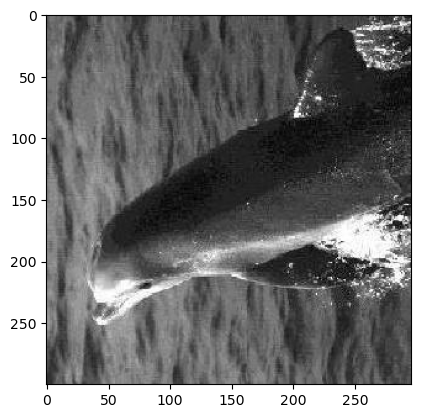

In [9]:
plt.imshow(img_rgb)

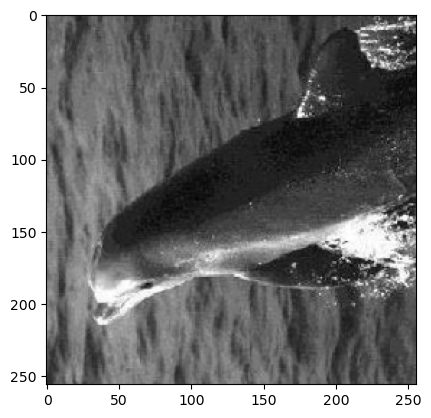

In [10]:
plt.imshow(img_rgb.resize((256, 256)))

Після того як завантажив датасет, то я був шокований від того що там було. Спочатку виправив у деяких фотографіях фон за допомгою заливки у (після повороту прозорий фон перетворився на чорний).

Також вилучив ті картинки, які вибиваються сильно від загальної "тенденції". Наприклад, дельфін Гектора серед картинок з дельфінами зустрічається в наборі лише один раз (якщо вірити зору автора).

Також знаходив дублі деяких фотографій (в буквальному сенсі, ніих відмінностей не було помічено).

Ручні виправлення мають місце, бо картинок не так багато, зокрема хороших лише одиниці. Так, на практиці майже ніхто таким не буде займатися, за винятком коли початковий набір даних є хорошим. Але саме цей датасет, мені здається, м'яко кажучи, поганим.

### Збір картинок докупи, попереднє зведення до єдиного розміру

In [11]:
labels = os.listdir(data)
label_to_idx = {label: j for j, label in enumerate(labels)}

IMG_SIZE = 256
N = sum(1 for l in labels for i in os.listdir(os.path.join(data, l)))
N

513

In [12]:
X = np.empty([N, 3, IMG_SIZE, IMG_SIZE])
Y = np.empty([N, 1])
(X.shape, Y.shape)

((513, 3, 256, 256), (513, 1))

In [13]:
k = 0

for i, label in enumerate(labels):
    path_to_imgs = os.path.join(data, label)
    
    for j, img_name in enumerate(os.listdir(path_to_imgs)):
        path_to_img = os.path.join(path_to_imgs, img_name)
        
        img = PIL.Image.open(path_to_img)
        
        img_new = PIL.Image.new("RGB", img.size)
        img_new.paste(img)
        
        img_new = img_new.resize((IMG_SIZE, IMG_SIZE))
        img_new = np.array(img_new)
        
        X[k,:,:,:] = np.transpose(img_new)
        Y[k,0] = label_to_idx[label]
        k += 1
        
X = X.astype(int)
Y = Y.astype(int)

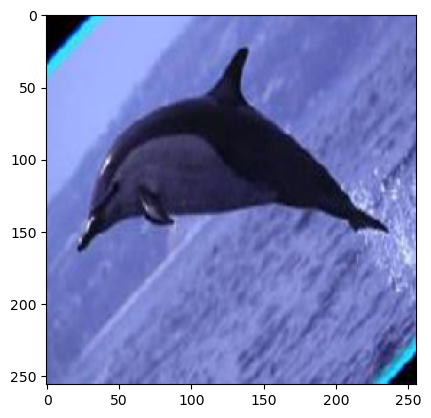

dolphin


In [14]:
plt.imshow(X[17,:,:,:].T)
plt.show()
print(labels[Y[17,0]])

Товстенький дельфін внаслідок спотворень розмірностей.

Ремарка від автора: попередньо пробував такий розв'язок "прокляття розмірності картинки, що варіюється":
1. Визначити довжину найбільшої сторони картинок.
2. Помістити усі картинки в центр, розтягнути зі збереженням пропорцій як можливо.
3. Ті порожні місця, що залишилися, замостити крайніми рядками картинки. Після цього додати до цих місць білий шум.

Головна біда в тому, що модель вивчала шум на деяких картинках, що, звісно, потягло за собою плачевні наслідки і прогнозувало, наприклад, дельфіна як гайковий ключ.

![Wrong classification](./legendary_pic.jpg)

Зокрема я не зберіг ніде ці розробки, та й не треба. Краще щось інше зробимо.

In [15]:
sizes = {label: 0 for label in labels}
for j in range(N):
    sizes[labels[Y[j,0]]] += 1
sizes

{'dolphin': 63,
 'gerenuk': 34,
 'wrench': 39,
 'chair': 62,
 'rooster': 49,
 'stop_sign': 64,
 'ketch': 114,
 'binocular': 33,
 'nautilus': 55}

Відберемо по десять штук фотографій з кожної підмножини в якості тестового датасету.

In [16]:
N_test_sub = 10

idx = np.arange(N)
idx_test = np.empty([N_test_sub * len(labels)])

np.random.seed(999)
for label in labels:
    j = label_to_idx[label]
    idx_label = idx[Y[:,0] == j]
    idx_label_test = np.random.choice(idx_label, N_test_sub, replace=False)
    idx_test[(j * N_test_sub):((j + 1) * N_test_sub)] = idx_label_test
    
idx_test = idx_test.astype(int)

In [17]:
idx_test

array([ 34,  61,  24,  52,  35,  46,  15,  55,  62,   9,  84,  93,  72,
        68,  65,  64,  73,  89,  76,  81, 111, 135, 121, 127, 133, 106,
       125, 110, 124, 126, 181, 179, 166, 185, 175, 171, 143, 173, 172,
       194, 239, 209, 205, 237, 199, 235, 226, 232, 241, 243, 258, 250,
       270, 288, 310, 301, 294, 255, 272, 298, 423, 368, 360, 379, 366,
       355, 418, 400, 334, 333, 425, 457, 452, 456, 428, 447, 454, 437,
       427, 450, 469, 508, 477, 480, 489, 496, 474, 473, 465, 471])

In [18]:
idx_test.shape

(90,)

In [19]:
np.random.shuffle(idx_test)
idx_test

array([471, 288,  65, 423,  76,  35, 121, 181, 243, 125, 143, 172, 508,
       235,  24,  84, 173, 133, 496, 171, 447, 226, 400, 255, 239, 310,
        62,  34, 334,  81,  89, 452, 469,  68, 457, 298, 209, 366, 205,
       237, 454, 368,  73, 379, 232, 199, 175, 473, 258,  15,   9, 427,
        93, 106, 250, 437, 127, 166, 270,  72, 428, 294, 418, 110, 450,
       477, 480,  52, 333, 355, 111, 241, 489,  64, 126,  55, 135, 185,
       301,  46,  61, 194, 456, 272, 425, 474, 179, 124, 360, 465])

Тоді набір тренувальних картинок -- ті індекси, що не є індексами тестового набору:

In [20]:
idx_train = np.setdiff1d(idx, idx_test)
np.random.shuffle(idx_train)
idx_train

array([267, 345, 500, 330, 145, 114, 352, 119, 420, 385, 256, 440, 117,
       157, 134, 393, 439, 215, 113, 320, 346, 365,  53,  70,  67, 407,
       131,  78,  37, 254, 468, 278, 430, 451, 289, 413, 351,   6, 370,
       438, 383, 115, 501, 401,   4, 495, 412, 109,  80, 177, 216, 382,
       261, 335,  49, 429, 266, 507, 307, 498, 358, 291,  54, 409, 318,
        86, 158, 306, 188, 236, 381,  45,  87,  71, 218, 353, 269, 414,
       497,   2,  51, 277, 163, 246, 395,   7, 331, 160, 148, 461, 410,
       442, 238, 184,   3,  74, 391, 201,  23, 367, 433, 204, 328, 491,
        48, 293, 322, 458, 186,  36, 499, 486,  95, 464, 347, 295, 221,
       485,  99, 299, 349, 384, 249, 245, 512,  59,  88, 483, 103,  85,
       141, 212, 476, 142, 229,  56, 380, 120, 404,  32,  12, 200, 467,
        39, 327, 405,  18, 233, 149, 168,  16, 228, 510, 394, 309, 455,
        83, 252, 146, 448, 419, 494,  41, 325, 283, 275,  47, 505, 319,
       506, 290, 389, 361, 313, 182, 139, 416, 167,  44, 118, 44

In [21]:
idx_train.shape

(423,)

Утворюємо тренувальний і тестовий набори картинок

In [22]:
X_train = X[idx_train,]
Y_train = Y[idx_train,]

X_test = X[idx_test,]
Y_test = Y[idx_test,]

### Підготовка DataLoader'ів

In [23]:
import torch
import torchvision
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Для відтворення результатів
torch.manual_seed(12345)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
reserved_mem = torch.cuda.memory_reserved(0) / 10e6
allocated_mem = torch.cuda.memory_allocated(0) / 10e6
str(round(reserved_mem - allocated_mem, 4)) + " mb"

'0.0 mb'

In [26]:
class ImageDataset(Dataset):
    def __init__(self, X, Y, transforms=None):
        """
        X - масив з зображень у вигляді багатовимірного масиву
        Y - масив з номерів класів, до яких відносяться зображення
        transform - перелік операцій над зображеннями з X
        """
        self.X = X
        self.Y = Y
        self.transforms = transforms
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        X_sample = self.X[idx,]
        Y_sample = self.Y[idx,]
        
        if self.transforms is not None:
            for transform in self.transforms:
                X_sample = transform(X_sample)
            
        return X_sample, Y_sample

In [27]:
batch_size = 40

In [28]:
train_ds = ImageDataset(X=X_train, Y=Y_train)
len(train_ds)

423

In [29]:
test_ds = ImageDataset(X=X_test, Y=Y_test)
len(test_ds)

90

In [30]:
train_ds[:][0].shape

(423, 3, 256, 256)

In [31]:
# help(DataLoader)

In [32]:
train_dl = DataLoader(dataset=train_ds, batch_size=batch_size)
test_dl = DataLoader(dataset=test_ds, batch_size=batch_size)

In [33]:
for item in train_dl:
    print(item[0].shape, item[1].shape)

torch.Size([40, 3, 256, 256]) torch.Size([40, 1])
torch.Size([40, 3, 256, 256]) torch.Size([40, 1])
torch.Size([40, 3, 256, 256]) torch.Size([40, 1])
torch.Size([40, 3, 256, 256]) torch.Size([40, 1])
torch.Size([40, 3, 256, 256]) torch.Size([40, 1])
torch.Size([40, 3, 256, 256]) torch.Size([40, 1])
torch.Size([40, 3, 256, 256]) torch.Size([40, 1])
torch.Size([40, 3, 256, 256]) torch.Size([40, 1])
torch.Size([40, 3, 256, 256]) torch.Size([40, 1])
torch.Size([40, 3, 256, 256]) torch.Size([40, 1])
torch.Size([23, 3, 256, 256]) torch.Size([23, 1])


Чудова штука, менше мороки при описі тренувального циклу. Тепер можна переходити до моделей.

### Спроба класифікації щільною нейронною мережею

In [34]:
class FeedForwardModel(nn.Module):
    
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, labels_size):
        """
        input_size = width = height of an image
        """
        super(self.__class__, self).__init__()
        
        # Normalization
        self.batchnorm1 = nn.BatchNorm2d(num_features=3)
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_size1)
        self.batchnorm3 = nn.BatchNorm1d(num_features=hidden_size2)
        
        # Network layers
        self.linear1 = nn.Linear(input_size * input_size * 3, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, labels_size)
        
        # Activations
        self.tanh1 = nn.Tanh()
        self.tanh2 = nn.Tanh()
        self.tanh3 = nn.Tanh()
        
        # Output activation
        # self.softmax = nn.Softmax()
        
    def forward(self, X):
        # Shut down tensor to vector
        X = self.batchnorm1(X)
        X = torch.flatten(input=X, start_dim=1)
        
        # Forward pass through network layers
        X = self.linear1(X)
        X = self.tanh1(X)
        
        X = self.batchnorm2(X)
        
        X = self.linear2(X)
        X = self.tanh2(X)
        
        X = self.batchnorm3(X)
        
        X = self.linear3(X)
        X = self.tanh3(X)
        
        out = self.linear4(X)
        # out = self.softmax(out)
        
        return out

In [35]:
# Ініціалізація моделі
model = FeedForwardModel(
    input_size=IMG_SIZE, 
    hidden_size1=IMG_SIZE * 2, 
    hidden_size2=IMG_SIZE, 
    hidden_size3=IMG_SIZE // 2,
    labels_size=len(labels)
)
model.to(device)

FeedForwardModel(
  (batchnorm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=196608, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=9, bias=True)
  (tanh1): Tanh()
  (tanh2): Tanh()
  (tanh3): Tanh()
)

In [36]:
epoch_loss_values = []
step_loss_values = []

In [37]:
# help(nn.CrossEntropyLoss)

In [38]:
# Функція вартості -- "мультикласова ентропія" 
loss_function = nn.CrossEntropyLoss()
# Використаємо ADAM в якості оптимізатора
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [39]:
n_epochs = 50
n_iters = len(train_dl)
n_tab = str(len(str(n_epochs)))

for epoch in range(n_epochs):
    epoch_loss = 0 
    
    for current_batch in train_dl:
        
        optimizer.zero_grad()
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        Y_batch = Y_batch.to(device)

        # Прогноз
        Y_pred = model(X_batch)
        
        loss = loss_function(Y_pred.squeeze(), torch.flatten(Y_batch))
        step_loss_values.append(loss)

        epoch_loss += loss.item() / n_iters
        
        loss.backward()
        optimizer.step()
    
    epoch_loss_values.append(epoch_loss)
            
    print(('Епоха {:' + n_tab + '}: сумарні втрати: {}').format(epoch+1, epoch_loss))    

Епоха  1: сумарні втрати: 1.776481650092385
Епоха  2: сумарні втрати: 1.445230484008789
Епоха  3: сумарні втрати: 1.29270356351679
Епоха  4: сумарні втрати: 1.1971215985038064
Епоха  5: сумарні втрати: 1.108338708227331
Епоха  6: сумарні втрати: 1.0157737081701104
Епоха  7: сумарні втрати: 0.9778805104168978
Епоха  8: сумарні втрати: 0.9662060845981946
Епоха  9: сумарні втрати: 0.9471887729384683
Епоха 10: сумарні втрати: 0.8949308666315946
Епоха 11: сумарні втрати: 0.8934855677864768
Епоха 12: сумарні втрати: 0.8012061146172611
Епоха 13: сумарні втрати: 0.8104778636585582
Епоха 14: сумарні втрати: 0.7857326540079985
Епоха 15: сумарні втрати: 0.8338046317750757
Епоха 16: сумарні втрати: 0.7356146926229651
Епоха 17: сумарні втрати: 0.7623866931958632
Епоха 18: сумарні втрати: 0.7277010652151975
Епоха 19: сумарні втрати: 0.8140139092098583
Епоха 20: сумарні втрати: 0.7481464635242115
Епоха 21: сумарні втрати: 0.6957951486110688
Епоха 22: сумарні втрати: 0.7753736322576349
Епоха 23: сумар

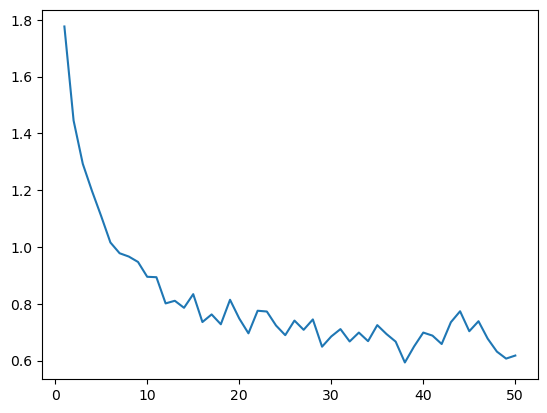

In [40]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

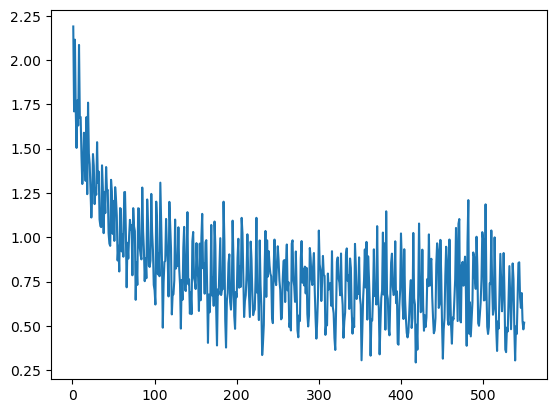

In [41]:
plt.plot(
    np.arange(1, n_iters * n_epochs + 1), 
    [v.cpu().detach().numpy() for v in step_loss_values]
)
plt.show()

In [42]:
del step_loss_values
del epoch_loss_values

Ситуація з підгонкою дуже погана. Можливо не вистачає даних для тренування (бо кількість параметрів для тренування явно більша за кількість наявних даних). Страшно дивитися, але треба побудувати таблицю правильних класифікацій.

In [43]:
Y_predicted_train = np.empty([0])

with torch.no_grad():
    for current_batch in train_dl:
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        Y_batch = Y_batch.to(device)

        # Прогноз
        Y_pred = model(X_batch)
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_train = np.append(Y_predicted_train, Y_pred_label)
        
        del X_batch
        del Y_batch
        del Y_pred_label
        torch.cuda.empty_cache()
        
Y_predicted_train.shape

(423,)

In [44]:
Y_predicted_test = np.empty([0])

with torch.no_grad():
    for current_batch in test_dl:
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        Y_batch = Y_batch.to(device)

        # Прогноз
        Y_pred = model(X_batch)
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_test = np.append(Y_predicted_test, Y_pred_label)
        
        del X_batch
        del Y_batch
        del Y_pred_label
        torch.cuda.empty_cache()
        
Y_predicted_test.shape

(90,)

In [45]:
Y_train.squeeze().shape, Y_test.squeeze().shape

((423,), (90,))

In [46]:
from sklearn.metrics import multilabel_confusion_matrix

In [47]:
# help(multilabel_confusion_matrix)

In [48]:
# 1st col ~ no effect, 2nd ~ has effect (labeled as ...)

In [49]:
conf_matr_train = multilabel_confusion_matrix(
    y_true=Y_train.squeeze(), 
    y_pred=Y_predicted_train.astype(int)
)
for k, label in enumerate(labels):
    print(label)
    print(conf_matr_train[k])

dolphin
[[365   5]
 [  9  44]]
gerenuk
[[395   4]
 [  8  16]]
wrench
[[392   2]
 [  7  22]]
chair
[[347  24]
 [ 11  41]]
rooster
[[375   9]
 [ 12  27]]
stop_sign
[[365   4]
 [ 12  42]]
ketch
[[315   4]
 [  9  95]]
binocular
[[392   8]
 [  1  22]]
nautilus
[[360  18]
 [  9  36]]


In [50]:
conf_matr_test = multilabel_confusion_matrix(
    y_true=Y_test.squeeze(), 
    y_pred=Y_predicted_test.astype(int)
)
for k, label in enumerate(labels):
    print(label)
    print(conf_matr_test[k])

dolphin
[[78  2]
 [ 2  8]]
gerenuk
[[80  0]
 [10  0]]
wrench
[[78  2]
 [ 3  7]]
chair
[[72  8]
 [ 7  3]]
rooster
[[73  7]
 [ 7  3]]
stop_sign
[[76  4]
 [ 5  5]]
ketch
[[73  7]
 [ 2  8]]
binocular
[[72  8]
 [ 4  6]]
nautilus
[[74  6]
 [ 4  6]]


In [51]:
def large_confusion_matrix(y_true, y_pred, labels, norm=False):
    output_matrix = np.zeros([len(labels), len(labels)]).astype(int)
    for j in range(len(y_true)):
        output_matrix[y_true[j], y_pred[j]] += 1
    if norm:
        for j in range(len(labels)):
            output_matrix = output_matrix.astype(float)
            output_matrix[j,] /= np.sum(output_matrix[j,])
    return output_matrix

In [52]:
cfm_test = large_confusion_matrix(
    y_true=Y_test.squeeze(), 
    y_pred=Y_predicted_test.astype(int), 
    labels=labels
)
large_confusion_matrix(
    y_true=Y_test.squeeze(), 
    y_pred=Y_predicted_test.astype(int), 
    labels=labels,
    norm=True
)

array([[0.8, 0. , 0. , 0. , 0. , 0.1, 0.1, 0. , 0. ],
       [0. , 0. , 0.2, 0.2, 0.4, 0.1, 0. , 0.1, 0. ],
       [0. , 0. , 0.7, 0.2, 0. , 0. , 0.1, 0. , 0. ],
       [0.1, 0. , 0. , 0.3, 0.1, 0. , 0.1, 0.1, 0.3],
       [0. , 0. , 0. , 0.2, 0.3, 0. , 0. , 0.4, 0.1],
       [0. , 0. , 0. , 0.1, 0.1, 0.5, 0.1, 0.1, 0.1],
       [0. , 0. , 0. , 0. , 0. , 0.1, 0.8, 0. , 0.1],
       [0.1, 0. , 0. , 0.1, 0.1, 0.1, 0. , 0.6, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.3, 0.1, 0.6]])

In [53]:
np.sum(np.diag(cfm_test)) / (N_test_sub * len(labels))

0.5111111111111111

Трохи нижче половини правильно вгаданих об'єктів на картинках. Звісно, можна було б розширити архітектуру нейронної мережі, але мій графічний процесор благає цього не робити (CUDA: Out Of Memory Error).

На тренувальному наборі ситуація така:

In [54]:
cfm_train = large_confusion_matrix(
    y_true=Y_train.squeeze(), 
    y_pred=Y_predicted_train.astype(int), 
    labels=labels
)
large_confusion_matrix(
    y_true=Y_train.squeeze(), 
    y_pred=Y_predicted_train.astype(int), 
    labels=labels,
    norm=True
)

array([[0.83018868, 0.01886792, 0.01886792, 0.01886792, 0.01886792,
        0.        , 0.03773585, 0.        , 0.05660377],
       [0.        , 0.66666667, 0.04166667, 0.08333333, 0.125     ,
        0.04166667, 0.        , 0.04166667, 0.        ],
       [0.06896552, 0.03448276, 0.75862069, 0.10344828, 0.        ,
        0.        , 0.        , 0.        , 0.03448276],
       [0.        , 0.01923077, 0.        , 0.78846154, 0.03846154,
        0.01923077, 0.01923077, 0.01923077, 0.09615385],
       [0.        , 0.        , 0.        , 0.20512821, 0.69230769,
        0.        , 0.        , 0.05128205, 0.05128205],
       [0.        , 0.        , 0.        , 0.01851852, 0.05555556,
        0.77777778, 0.01851852, 0.03703704, 0.09259259],
       [0.01923077, 0.00961538, 0.        , 0.        , 0.        ,
        0.01923077, 0.91346154, 0.01923077, 0.01923077],
       [0.        , 0.        , 0.        , 0.04347826, 0.        ,
        0.        , 0.        , 0.95652174, 0.        ],


In [55]:
np.sum(np.diag(cfm_train)) / (N - N_test_sub * len(labels))

0.8156028368794326

Ну, трохи краще. Але то є відносним мірилом, бо то ж на тренуванні вже біда.

In [56]:
del model
del loss_function
del optimizer
torch.cuda.empty_cache()

Як розв'язати проблему?
1. Урізноманітнити вибірку за допомогою трансформацій над картинками
2. Застосувати згорткові нейронні мережі, щоб помилувати GPU [жарт].

Почнемо з першого пункту. Ми опишемо додаткові трансформації на картинки.

In [57]:
transforms_custom = [
    torch.from_numpy,
    lambda u: u.type(torch.FloatTensor),
    T.RandomCrop(250),
    T.CenterCrop(200),
    T.RandomRotation(60),
    T.RandomVerticalFlip(0.25),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

In [58]:
del train_ds
del train_dl
del test_ds
del test_dl

Реініціалізуємо наші набори даних та підвантажувачі. 

In [59]:
batch_size_new = 71 # Тоді залишок на останньому пакеті буде оптимальним, 69

In [60]:
train_ds = ImageDataset(
    X=X_train, Y=Y_train, transforms=transforms_custom
)
train_dl = DataLoader(
    dataset=train_ds, batch_size=batch_size_new
)

In [61]:
test_ds = ImageDataset(
    X=X_test, Y=Y_test, transforms=transforms_custom
)
test_dl = DataLoader(
    dataset=test_ds, batch_size=batch_size_new
)

Тепер головний гість заходу: згорткова мережа.

Параметрів буде багатенько, тому треба якось боротися із можливим затуханням градієнта. Наприклад, я зроблю це нормалізацією пакетів. Drop-out відкладає затухання лише на ''потім'' (в даному випадку). Доведення не наводиться, аби не смітити в блокноті.

In [62]:
class ConvolutionModel(nn.Module):
    
    def __init__(self, labels_size=len(labels)):
        super(self.__class__, self).__init__()
        # 3 x 100 x 100
        
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=6,
            kernel_size=13
        )
        # 6 x (200 - 13 + 1) x (200 - 13 + 1) = 6 x 188 x 188
        
        self.pool = nn.MaxPool2d(2, 2)
        # 6 x ((188 - 2)/2 + 1) x ((188 - 2)/2 + 1) = 6 x 94 x 94
        
        self.conv2 = nn.Conv2d(
            in_channels=6, 
            out_channels=18, 
            kernel_size=13
        )
        # 18 x (94 - 13 + 1) x (94 - 13 + 1) = 18 x 82 x 82
        
        # pool: 18 x ((82 - 2)/2 + 1) x ((82 - 2)/2 + 1) = 18 x 41 x 41
        
        self.conv3 = nn.Conv2d(
            in_channels=18, 
            out_channels=24, 
            kernel_size=13
        )
        # 24 x (41 - 13 + 1) x (41 - 13 + 1) = 24 x 29 x 29
        
        # pool: 24 x ((29 - 2)/2 + 1) x ((29 - 2)/2 + 1) = 24 x 14 x 14
        
        
        self.linear1 = nn.Linear(24 * 14 * 14, 900)
        # 4704 -> 900
        
        self.linear2 = nn.Linear(900, 300)
        # 900 -> 300
        
        self.linear3 = nn.Linear(300, 80)
        # 300 -> 80
        
        self.linear4 = nn.Linear(80, labels_size)
        # 80 -[def]-> 9
        
        self.batchnormcnn1 = nn.BatchNorm2d(6)
        self.batchnormcnn2 = nn.BatchNorm2d(18)
        self.batchnormcnn3 = nn.BatchNorm2d(24)
        
        #self.dropout = nn.Dropout(0.3)
        self.batchnorm0 = nn.BatchNorm1d(4704)
        self.batchnorm1 = nn.BatchNorm1d(900)
        self.batchnorm2 = nn.BatchNorm1d(300)
        self.batchnorm3 = nn.BatchNorm1d(80)
    
    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.batchnormcnn1(X)
        
        X = self.pool(F.relu(self.conv2(X)))
        X = self.batchnormcnn2(X)
        
        X = self.pool(F.relu(self.conv3(X)))
        X = self.batchnormcnn3(X)
        
        X = torch.flatten(input=X, start_dim=1)
        #X = self.dropout(X)
        X = self.batchnorm0(X)
        
        X = F.relu(self.linear1(X))
        #X = self.dropout(X)
        X = self.batchnorm1(X)
        
        X = F.relu(self.linear2(X))
        #X = self.dropout(X)
        X = self.batchnorm2(X)
        
        X = F.relu(self.linear3(X))
        #X = self.dropout(X)
        X = self.batchnorm3(X)
        
        out = self.linear4(X)
        
        return out

In [63]:
# Ініціалізація моделі
model = ConvolutionModel()
model.to(device)

ConvolutionModel(
  (conv1): Conv2d(3, 6, kernel_size=(13, 13), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 18, kernel_size=(13, 13), stride=(1, 1))
  (conv3): Conv2d(18, 24, kernel_size=(13, 13), stride=(1, 1))
  (linear1): Linear(in_features=4704, out_features=900, bias=True)
  (linear2): Linear(in_features=900, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=80, bias=True)
  (linear4): Linear(in_features=80, out_features=9, bias=True)
  (batchnormcnn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnormcnn2): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnormcnn3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm0): BatchNorm1d(4704, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm1): BatchNorm1d(900, eps=1e-05, momentum=0.1

In [64]:
epoch_loss_values = []
step_loss_values = []

In [65]:
# Функція вартості -- "мультикласова ентропія" 
loss_function = nn.CrossEntropyLoss()
# Використаємо ADAM в якості оптимізатора
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [66]:
n_epochs = 80
n_iters = len(train_dl)
n_tab = str(len(str(n_epochs)))

for epoch in range(n_epochs):
    epoch_loss = 0 
    
    for current_batch in train_dl:
        
        optimizer.zero_grad()
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        # Прогноз
        Y_pred = model(X_batch)
        
        loss = loss_function(Y_pred.squeeze(), torch.flatten(Y_batch))
        step_loss_values.append(loss)

        epoch_loss += loss.item() / n_iters
        
        loss.backward()
        optimizer.step()
    
    epoch_loss_values.append(epoch_loss)
            
    print(('Епоха {:' + n_tab + '}: сумарні втрати: {}').format(epoch+1, epoch_loss))    

Епоха  1: сумарні втрати: 2.1318487326304116
Епоха  2: сумарні втрати: 1.6347440481185913
Епоха  3: сумарні втрати: 1.5037625829378765
Епоха  4: сумарні втрати: 1.4103888074556987
Епоха  5: сумарні втрати: 1.353904704252879
Епоха  6: сумарні втрати: 1.2712860306104024
Епоха  7: сумарні втрати: 1.183147092660268
Епоха  8: сумарні втрати: 1.1123227973779042
Епоха  9: сумарні втрати: 1.098252296447754
Епоха 10: сумарні втрати: 1.016707529624303
Епоха 11: сумарні втрати: 1.0091944336891174
Епоха 12: сумарні втрати: 0.9668665329615276
Епоха 13: сумарні втрати: 0.9256881276766459
Епоха 14: сумарні втрати: 0.8590836624304454
Епоха 15: сумарні втрати: 0.7977055211861928
Епоха 16: сумарні втрати: 0.7306101123491924
Епоха 17: сумарні втрати: 0.6312321424484253
Епоха 18: сумарні втрати: 0.6551364163557688
Епоха 19: сумарні втрати: 0.6010907590389252
Епоха 20: сумарні втрати: 0.6040253241856893
Епоха 21: сумарні втрати: 0.5644708375136057
Епоха 22: сумарні втрати: 0.5620052615801494
Епоха 23: сума

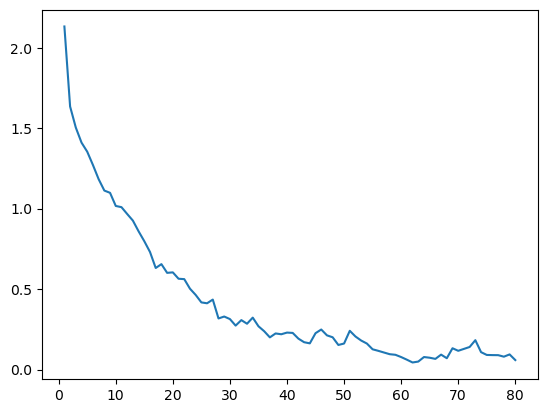

In [67]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

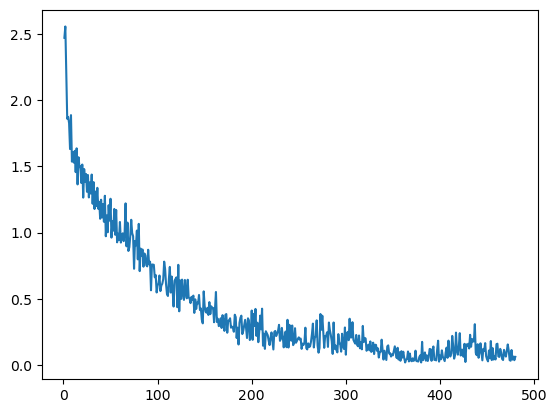

In [68]:
plt.plot(
    np.arange(1, n_iters * n_epochs + 1), 
    [v.cpu().detach().numpy() for v in step_loss_values]
)
plt.show()

Перевірка:

In [69]:
Y_predicted_train = np.empty([0])

with torch.no_grad():
    for current_batch in train_dl:
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        Y_batch = Y_batch.to(device)

        # Прогноз
        Y_pred = model(X_batch)
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_train = np.append(Y_predicted_train, Y_pred_label)
        
        del X_batch
        del Y_batch
        del Y_pred_label
        torch.cuda.empty_cache()
        
Y_predicted_train.shape

(423,)

In [70]:
Y_predicted_test = np.empty([0])

with torch.no_grad():
    for current_batch in test_dl:
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        Y_batch = Y_batch.to(device)

        # Прогноз
        Y_pred = model(X_batch)
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_test = np.append(Y_predicted_test, Y_pred_label)
        
        del X_batch
        del Y_batch
        del Y_pred_label
        torch.cuda.empty_cache()
        
Y_predicted_test.shape

(90,)

In [71]:
conf_matr_train = multilabel_confusion_matrix(
    y_true=Y_train.squeeze(), 
    y_pred=Y_predicted_train.astype(int)
)
for k, label in enumerate(labels):
    print(label)
    print(conf_matr_train[k])

dolphin
[[369   1]
 [  1  52]]
gerenuk
[[399   0]
 [  1  23]]
wrench
[[393   1]
 [  3  26]]
chair
[[370   1]
 [  0  52]]
rooster
[[384   0]
 [  2  37]]
stop_sign
[[369   0]
 [  0  54]]
ketch
[[317   2]
 [  1 103]]
binocular
[[399   1]
 [  1  22]]
nautilus
[[375   3]
 [  0  45]]


In [72]:
conf_matr_test = multilabel_confusion_matrix(
    y_true=Y_test.squeeze(), 
    y_pred=Y_predicted_test.astype(int)
)
for k, label in enumerate(labels):
    print(label)
    print(conf_matr_test[k])

dolphin
[[77  3]
 [ 3  7]]
gerenuk
[[79  1]
 [ 9  1]]
wrench
[[79  1]
 [ 5  5]]
chair
[[67 13]
 [ 4  6]]
rooster
[[76  4]
 [ 5  5]]
stop_sign
[[77  3]
 [ 1  9]]
ketch
[[70 10]
 [ 1  9]]
binocular
[[77  3]
 [ 5  5]]
nautilus
[[76  4]
 [ 9  1]]


In [73]:
cfm_test = large_confusion_matrix(
    y_true=Y_test.squeeze(), 
    y_pred=Y_predicted_test.astype(int), 
    labels=labels
)
large_confusion_matrix(
    y_true=Y_test.squeeze(), 
    y_pred=Y_predicted_test.astype(int), 
    labels=labels,
    norm=True
)

array([[0.7, 0.1, 0. , 0.1, 0. , 0. , 0.1, 0. , 0. ],
       [0. , 0.1, 0. , 0.4, 0.1, 0.1, 0.2, 0.1, 0. ],
       [0.1, 0. , 0.5, 0. , 0.2, 0. , 0.1, 0. , 0.1],
       [0. , 0. , 0. , 0.6, 0. , 0.2, 0.1, 0. , 0.1],
       [0. , 0. , 0. , 0.4, 0.5, 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0.1],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0.9, 0. , 0. ],
       [0.1, 0. , 0.1, 0. , 0. , 0. , 0.2, 0.5, 0.1],
       [0.1, 0. , 0. , 0.3, 0.1, 0. , 0.3, 0.1, 0.1]])

In [74]:
np.sum(np.diag(cfm_test)) / (N_test_sub * len(labels))

0.5333333333333333

На тренувальному наборі ситуація така:

In [75]:
cfm_train = large_confusion_matrix(
    y_true=Y_train.squeeze(), 
    y_pred=Y_predicted_train.astype(int), 
    labels=labels
)
large_confusion_matrix(
    y_true=Y_train.squeeze(), 
    y_pred=Y_predicted_train.astype(int), 
    labels=labels,
    norm=True
)

array([[0.98113208, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01886792],
       [0.        , 0.95833333, 0.        , 0.04166667, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.89655172, 0.        , 0.        ,
        0.        , 0.06896552, 0.        , 0.03448276],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.02564103, 0.        , 0.94871795,
        0.        , 0.        , 0.02564103, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.00961538, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.99038462, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.95652174, 0.04347826],


In [76]:
np.sum(np.diag(cfm_train)) / (N - N_test_sub * len(labels))

0.9787234042553191

Вас вітає overfit. Спробуємо спростити модель.

In [77]:
del model
del loss_function
del optimizer
torch.cuda.empty_cache()

In [78]:
class ConicModel(nn.Module):
    
    def __init__(self, labels_size=len(labels)):
        super(self.__class__, self).__init__()
        # 3 x 200 x 200
        
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=5,
            kernel_size=5
        )
        # (200 - 5 + 1) = 200 - 4 = 194
        # 5 x 194 x 194
        
        self.pool = nn.MaxPool2d(2, 2)
        # (194 - 2) / 2 + 1 = 192 / 2 + 1 = 96 + 1 = 97
        # 5 x 97 x 97
        
        self.conv2 = nn.Conv2d(
            in_channels=5,
            out_channels=7,
            kernel_size=5
        )
        # 97 - 5 + 1 = 97 - 4 = 93
        # 7 x 93 x 93
        
        # [(93 - 2) / 2] + 1 = [91 / 2] + 1 = 45 + 1 = 46
        # 7 x 46 x 46
        
        self.conv3 = nn.Conv2d(
            in_channels=7,
            out_channels=9,
            kernel_size=5
        )
        # 46 - 5 + 1 = 46 - 4 = 42
        # 9 x 42 x 42
        
        # (42 - 2) / 2 + 1 = 40 / 2 + 1 = 21
        # 9 x 21 x 21
        
        self.conv4 = nn.Conv2d(
            in_channels=9,
            out_channels=15,
            kernel_size=5
        )
        # 21 - 5 + 1 = 21 - 4 = 17
        # 15 x 17 x 17
        
        # [(17 - 2) / 2] + 1 = [15 / 2] + 1 = 7 + 1 = 8
        # 15 x 8 x 8
        
        self.conv5 = nn.Conv2d(
            in_channels=15,
            out_channels=24,
            kernel_size=5
        )
        # 8 - 5 + 1 = 8 - 4 = 4
        # 24 x 4 x 4      
        
        self.linear1 = nn.Linear(24 * 4 * 4, 100)
        # 384 -> 100
        
        self.linear2 = nn.Linear(100, labels_size)
        # 100 -> 9
        
        # Regularization
        
        self.batchnormcnn1 = nn.BatchNorm2d(5)
        self.batchnormcnn2 = nn.BatchNorm2d(7)
        self.batchnormcnn3 = nn.BatchNorm2d(9)
        self.batchnormcnn4 = nn.BatchNorm2d(15)
        self.batchnormcnn5 = nn.BatchNorm2d(24)
        
        self.batchnorm0 = nn.BatchNorm1d(24 * 4 * 4)
        self.batchnorm1 = nn.BatchNorm1d(100)
        
    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.batchnormcnn1(X)
        
        X = self.pool(F.relu(self.conv2(X)))
        X = self.batchnormcnn2(X)
        
        X = self.pool(F.relu(self.conv3(X)))
        X = self.batchnormcnn3(X)
        
        X = self.pool(F.relu(self.conv4(X)))
        X = self.batchnormcnn4(X)
        
        X = F.relu(self.conv5(X))
        X = self.batchnormcnn5(X)
        
        X = torch.flatten(input=X, start_dim=1)
        X = self.batchnorm0(X)
        
        X = F.relu(self.linear1(X))
        X = self.batchnorm1(X)
        
        out = self.linear2(X)
        
        return out

In [79]:
# Ініціалізація моделі
model = ConicModel()
model.to(device)

ConicModel(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 7, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(7, 9, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(9, 15, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(15, 24, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=384, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=9, bias=True)
  (batchnormcnn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnormcnn2): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnormcnn3): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnormcnn4): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnormcnn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_run

In [80]:
epoch_loss_values = []
step_loss_values = []

In [81]:
# Функція вартості -- "мультикласова ентропія" 
loss_function = nn.CrossEntropyLoss()
# Використаємо ADAM в якості оптимізатора
optimizer = torch.optim.Adam(model.parameters(), lr=0.0075)

In [82]:
n_epochs = 80
n_iters = len(train_dl)
n_tab = str(len(str(n_epochs)))

for epoch in range(n_epochs):
    epoch_loss = 0 
    
    for current_batch in train_dl:
        
        optimizer.zero_grad()
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        # Прогноз
        Y_pred = model(X_batch)
        
        loss = loss_function(Y_pred.squeeze(), torch.flatten(Y_batch))
        step_loss_values.append(loss)

        epoch_loss += loss.item() / n_iters
        
        loss.backward()
        optimizer.step()
    
    epoch_loss_values.append(epoch_loss)
            
    print(('Епоха {:' + n_tab + '}: сумарні втрати: {}').format(epoch+1, epoch_loss))    

Епоха  1: сумарні втрати: 2.041369279225667
Епоха  2: сумарні втрати: 1.571417490641276
Епоха  3: сумарні втрати: 1.4599337776501973
Епоха  4: сумарні втрати: 1.3692394693692524
Епоха  5: сумарні втрати: 1.3385505080223083
Епоха  6: сумарні втрати: 1.2581717371940613
Епоха  7: сумарні втрати: 1.1897812485694885
Епоха  8: сумарні втрати: 1.143987556298574
Епоха  9: сумарні втрати: 1.0312276979287465
Епоха 10: сумарні втрати: 1.0249392886956532
Епоха 11: сумарні втрати: 1.015849530696869
Епоха 12: сумарні втрати: 0.972243477900823
Епоха 13: сумарні втрати: 0.9918353259563446
Епоха 14: сумарні втрати: 0.8821442226568859
Епоха 15: сумарні втрати: 0.8816020588080088
Епоха 16: сумарні втрати: 0.8339475194613138
Епоха 17: сумарні втрати: 0.7469066182772318
Епоха 18: сумарні втрати: 0.7088882227738698
Епоха 19: сумарні втрати: 0.6984820167223612
Епоха 20: сумарні втрати: 0.6505280236403147
Епоха 21: сумарні втрати: 0.6189096868038176
Епоха 22: сумарні втрати: 0.6072127272685368
Епоха 23: сумар

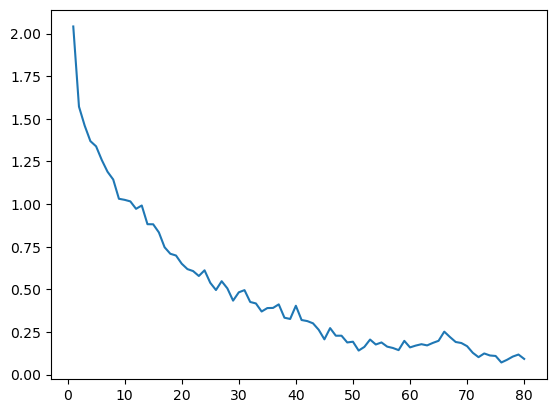

In [83]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

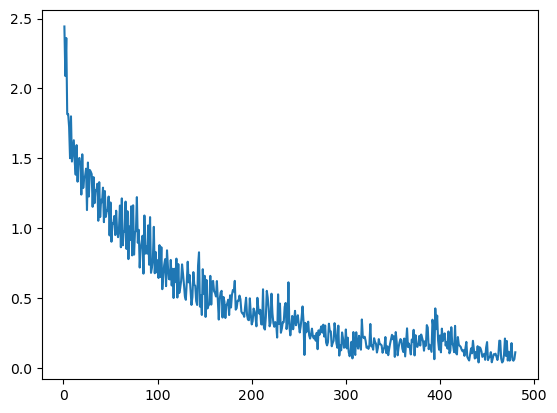

In [84]:
plt.plot(
    np.arange(1, n_iters * n_epochs + 1), 
    [v.cpu().detach().numpy() for v in step_loss_values]
)
plt.show()

Перевірка:

In [85]:
Y_predicted_train = np.empty([0])

with torch.no_grad():
    for current_batch in train_dl:
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        Y_batch = Y_batch.to(device)

        # Прогноз
        Y_pred = model(X_batch)
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_train = np.append(Y_predicted_train, Y_pred_label)
        
        del X_batch
        del Y_batch
        del Y_pred_label
        torch.cuda.empty_cache()
        
Y_predicted_train.shape

(423,)

In [86]:
Y_predicted_test = np.empty([0])

with torch.no_grad():
    for current_batch in test_dl:
        
        X_batch, Y_batch = current_batch
        X_batch = X_batch.type(torch.FloatTensor).to(device)
        Y_batch = Y_batch.to(device)

        # Прогноз
        Y_pred = model(X_batch)
        Y_pred_norm = F.softmax(Y_pred, dim=1)
        Y_pred_label = Y_pred_norm.argmax(dim=1)
        Y_pred_label = Y_pred_label.detach().cpu().numpy()
        Y_predicted_test = np.append(Y_predicted_test, Y_pred_label)
        
        del X_batch
        del Y_batch
        del Y_pred_label
        torch.cuda.empty_cache()
        
Y_predicted_test.shape

(90,)

In [87]:
conf_matr_train = multilabel_confusion_matrix(
    y_true=Y_train.squeeze(), 
    y_pred=Y_predicted_train.astype(int)
)
for k, label in enumerate(labels):
    print(label)
    print(conf_matr_train[k])

dolphin
[[367   3]
 [  4  49]]
gerenuk
[[399   0]
 [  2  22]]
wrench
[[393   1]
 [  1  28]]
chair
[[370   1]
 [  2  50]]
rooster
[[384   0]
 [  0  39]]
stop_sign
[[369   0]
 [  0  54]]
ketch
[[314   5]
 [  2 102]]
binocular
[[400   0]
 [  1  22]]
nautilus
[[376   2]
 [  0  45]]


In [88]:
conf_matr_test = multilabel_confusion_matrix(
    y_true=Y_test.squeeze(), 
    y_pred=Y_predicted_test.astype(int)
)
for k, label in enumerate(labels):
    print(label)
    print(conf_matr_test[k])

dolphin
[[76  4]
 [ 3  7]]
gerenuk
[[80  0]
 [ 7  3]]
wrench
[[79  1]
 [ 5  5]]
chair
[[68 12]
 [ 4  6]]
rooster
[[78  2]
 [ 3  7]]
stop_sign
[[78  2]
 [ 2  8]]
ketch
[[74  6]
 [ 0 10]]
binocular
[[80  0]
 [ 5  5]]
nautilus
[[74  6]
 [ 4  6]]


In [89]:
cfm_test = large_confusion_matrix(
    y_true=Y_test.squeeze(), 
    y_pred=Y_predicted_test.astype(int), 
    labels=labels
)
large_confusion_matrix(
    y_true=Y_test.squeeze(), 
    y_pred=Y_predicted_test.astype(int), 
    labels=labels,
    norm=True
)

array([[0.7, 0. , 0. , 0.2, 0.1, 0. , 0. , 0. , 0. ],
       [0.1, 0.3, 0.1, 0.3, 0. , 0.1, 0. , 0. , 0.1],
       [0. , 0. , 0.5, 0.2, 0. , 0. , 0.2, 0. , 0.1],
       [0. , 0. , 0. , 0.6, 0.1, 0.1, 0.1, 0. , 0.1],
       [0.1, 0. , 0. , 0.1, 0.7, 0. , 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0.2],
       [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0.3, 0. , 0. , 0.1, 0.5, 0.1],
       [0.2, 0. , 0. , 0.1, 0. , 0. , 0.1, 0. , 0.6]])

In [90]:
np.sum(np.diag(cfm_test)) / (N_test_sub * len(labels))

0.6333333333333333

На тренувальному наборі ситуація така:

In [91]:
cfm_train = large_confusion_matrix(
    y_true=Y_train.squeeze(), 
    y_pred=Y_predicted_train.astype(int), 
    labels=labels
)
large_confusion_matrix(
    y_true=Y_train.squeeze(), 
    y_pred=Y_predicted_train.astype(int), 
    labels=labels,
    norm=True
)

array([[0.9245283 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.0754717 , 0.        , 0.        ],
       [0.        , 0.91666667, 0.        , 0.04166667, 0.        ,
        0.        , 0.        , 0.        , 0.04166667],
       [0.        , 0.        , 0.96551724, 0.        , 0.        ,
        0.        , 0.03448276, 0.        , 0.        ],
       [0.01923077, 0.        , 0.        , 0.96153846, 0.        ,
        0.        , 0.        , 0.        , 0.01923077],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.00961538, 0.        , 0.00961538, 0.        , 0.        ,
        0.        , 0.98076923, 0.        , 0.        ],
       [0.04347826, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.95652174, 0.        ],


In [92]:
np.sum(np.diag(cfm_train)) / (N - N_test_sub * len(labels))

0.9716312056737588